# TensorFlow 数据集

TensorFlow Datasets 提供了一系列可以和 TensorFlow 配合使用的数据集。它负责下载和准备数据，以及构建 [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)。

Copyright 2018 The TensorFlow Datasets Authors, Licensed under the Apache License, Version 2.0

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/datasets/overview"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/datasets/blob/master/docs/overview.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.google.cn/datasets/overview"><img src="https://www.tensorflow.google.cn/images/tf_logo_32px.png" />在 tensorflow.google.cn 上查看</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb"><img src="https://www.tensorflow.google.cn/images/colab_logo_32px.png" />在 Google Colab 运行</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/datasets/blob/master/docs/overview.ipynb"><img src="https://www.tensorflow.google.cn/images/GitHub-Mark-32px.png" />在 Github 上查看源代码</a>
  </td>
</table>

## 安装

`pip install tensorflow-datasets`

注意使用 `tensorflow-datasets` 的前提是已经安装好 TensorFlow，目前支持的版本是 `tensorflow` (或者 `tensorflow-gpu`) >= `1.15.0`

In [ ]:
!pip install -q tensorflow tensorflow-datasets matplotlib

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

## Eager execution

TensorFlow 数据集同时兼容 TensorFlow [Eager 模式](https://tensorflow.google.cn/guide/eager) 和图模式。在这个 colab 环境里面，我们的代码将通过 Eager 模式执行。

In [2]:
tf.compat.v1.enable_eager_execution()

## 列出可用的数据集

每一个数据集（dataset）都实现了抽象基类 [`tfds.core.DatasetBuilder`](https://www.tensorflow.google.cn/datasets/api_docs/python/tfds/core/DatasetBuilder) 来构建。你可以通过 `tfds.list_builders()` 列出所有可用的数据集。

你可以通过 [数据集文档页](https://www.tensorflow.google.cn/datasets/catalog/overview) 查看所有支持的数据集及其补充文档。

In [3]:
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'bair_robot_pushing_small',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco2014',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'eurosat',
 'fashion_mnist',
 'flores',
 'food101',
 'gap',
 'gigaword',
 'glue',
 'groove',
 'higgs',
 'horses_or_humans',
 'image_label_folder',
 'imagenet2012',
 'imagenet2012_corrupted',
 'imagenet_resized',
 'imdb_reviews',
 'iris',
 '

## `tfds.load`: 一行代码获取数据集

[`tfds.load`](https://www.tensorflow.google.cn/datasets/api_docs/python/tfds/load) 是构建并加载 `tf.data.Dataset` 最简单的方式。

`tf.data.Dataset` 是构建输入流水线的标准 TensorFlow 接口。如果你对这个接口不熟悉，我们强烈建议你阅读 [TensorFlow 官方指南](https://www.tensorflow.google.cn/guide/datasets)。

下面，我们先加载 MNIST 训练数据。这个步骤会下载并准备好该数据，除非你显式指定 `download=False`。值得注意的是，一旦该数据准备好了，后续的 `load` 命令便不会重新下载，可以重复使用准备好的数据。
你可以通过指定 `data_dir=` (默认是 `~/tensorflow_datasets/`) 来自定义数据保存/加载的路径。

In [4]:
mnist_train = tfds.load(name="mnist", split="train")
assert isinstance(mnist_train, tf.data.Dataset)
print(mnist_train)

<DatasetV1Adapter shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


加载数据集时，将使用规范的默认版本。 但是，建议你指定要使用的数据集的主版本，并在结果中表明使用了哪个版本的数据集。更多详情请参考[数据集版本控制文档](https://github.com/tensorflow/datasets/blob/master/docs/)。

In [5]:
mnist = tfds.load("mnist:1.*.*")

## 特征字典

所有 `tfds` 数据集都包含将特征名称映射到 Tensor 值的特征字典。 典型的数据集（如 MNIST）将具有2个键：`"image"` 和 `"label"`。 下面我们看一个例子。

注意：在图模式（graph mode）下，请参阅 [tf.data 指南](https://www.tensorflow.google.cn/guide/datasets#creating_an_iterator) 以了解如何在 `tf.data.Dataset` 上进行迭代。

Label: 3


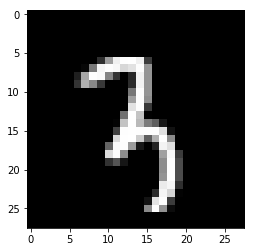

In [6]:
for mnist_example in mnist_train.take(1):  # 只取一个样本
    image, label = mnist_example["image"], mnist_example["label"]

    plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap("gray"))
    print("Label: %d" % label.numpy())

## `DatasetBuilder`

`tfds.load` 实际上是一个基于 `DatasetBuilder` 的简单方便的包装器。我们可以直接使用 MNIST `DatasetBuilder` 实现与上述相同的操作。

In [7]:
mnist_builder = tfds.builder("mnist")
mnist_builder.download_and_prepare()
mnist_train = mnist_builder.as_dataset(split="train")
mnist_train

<DatasetV1Adapter shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>

## 输入流水线

一旦有了 `tf.data.Dataset` 对象，就可以使用 [`tf.data` 接口](https://www.tensorflow.google.cn/guide/datasets) 定义适合模型训练的输入流水线的其余部分。

在这里，我们将重复使用数据集，以便有无限的样本流，然后随机打乱并创建大小为32的批。

In [8]:
mnist_train = mnist_train.repeat().shuffle(1024).batch(32)

# prefetch 将使输入流水线可以在模型训练时异步获取批处理。
mnist_train = mnist_train.prefetch(tf.data.experimental.AUTOTUNE)

# 现在你可以遍历数据集的批次并在 mnist_train 中训练批次：
#   ...

## 数据集信息（DatasetInfo）

生成后，构建器将包含有关数据集的有用信息：

In [9]:
info = mnist_builder.info
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    urls=['https://storage.googleapis.com/cvdf-datasets/mnist/'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



`DatasetInfo` 还包含特征相关的有用信息：

In [10]:
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
10
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


你也可以通过 `tfds.load` 使用 `with_info = True` 加载 `DatasetInfo`。

In [11]:
mnist_test, info = tfds.load("mnist", split="test", with_info=True)
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    urls=['https://storage.googleapis.com/cvdf-datasets/mnist/'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



## 可视化

对于图像分类数据集，你可以使用 `tfds.show_examples` 来可视化一些样本。

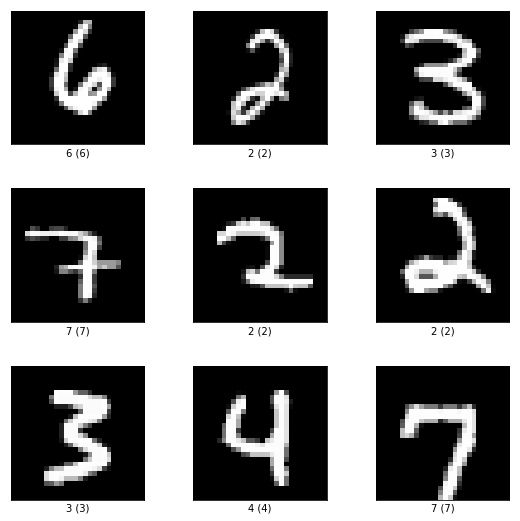

In [12]:
fig = tfds.show_examples(info, mnist_test)